In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import copy

matplotlib.rcParams['figure.figsize'] = (12, 8)

#### Dataset 0

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

#### Dataset 1

In [64]:
x1min, x1max, nx1 = -5, 4, 75
x2min, x2max, nx2 = -3, 7, 75
x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
X1, X2 = np.meshgrid(x1, x2)

def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]
Y = np.zeros(X1.shape)
for p in gprms:
    Y += gaussian(X1, X2, *p)

#### Scaling/Plotting the data

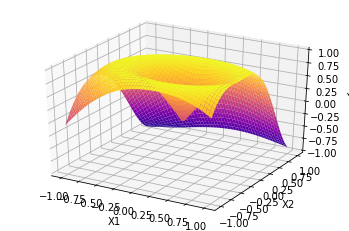

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [4]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Using Weights first and then bias

In [39]:
optimizer = tnn.Adam()
n_hidden=2
layer1_weights = tnn.WeightsLayer(2,n_hidden, optimizer=optimizer)
layer1_bias = tnn.BiasLayer(n_hidden, optimizer=optimizer)
layer1_weightT = tnn.WeightsLayer(n_hidden,2)
layer2 = tnn.DoubleReluLinearLayer(n_hidden,1, optimizer=optimizer)

In [40]:
err2_out = []
err2_rec = []

In [41]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):
    layer1_weightT.weights = layer1_weights.weights.T
#     layer1_weightT.weights = np.linalg.pinv(layer1_weights.weights)
    
    
    norm1 = layer1_weights.forward(xx)
    recx = layer1_weightT.forward(norm1)

    drecx = (recx - xx)
    dnorm1 = layer1_weightT.backward(drecx)
    dx = layer1_weights.backward(dnorm1)
    
    layer1_weights.update()
    
    norm1 = layer1_weights.forward(xx)
    cent1 = layer1_bias.forward(norm1)
    yout = layer2.forward(cent1)
    
    dy = yout - yy
    dcent1 = layer2.backward(dy)
    dnorm1 = layer1_bias.backward(dcent1)
    dx = layer1_weights.backward(dnorm1)
    
    layer1_bias.update()
    layer1_weights.update()
    layer2.update()
    
    if epoch%100 == 0:
            
        error = (dy**2).mean()
        error2 = (drecx**2).mean()
        err2_out.append(error)
        err2_rec.append(error2)
        print(epoch, f'Error_output = {error} , error_recons = {error2}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.1)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error_output = 0.2416897370504368 , error_recons = 0.16984512220756345


100 Error_output = 0.112909940738932 , error_recons = 0.00013020691969762666


200 Error_output = 0.08436807855717796 , error_recons = 7.294503859169438e-05


300 Error_output = 0.07652853203411897 , error_recons = 0.00024242571569921061


400 Error_output = 0.06904497199946404 , error_recons = 0.0005222893861859177


500 Error_output = 0.06520966392175588 , error_recons = 0.00024258559426571438


600 Error_output = 0.0641466221919765 , error_recons = 0.00016639129239468716


700 Error_output = 0.06381865028006248 , error_recons = 0.00013880773480758022


800 Error_output = 0.06372397872260879 , error_recons = 0.00013279933296447244


900 Error_output = 0.06369967270627878 , error_recons = 0.00012858113839965752


1000 Error_output = 0.06369409073425365 , error_recons = 0.00012737159425687348


1100 Error_output = 0.0636919216813568 , error_recons = 0.00012836562098004125


1200 Error_output = 0.0636920688009207

TclError: can't invoke "update" command: application has been destroyed

In [42]:
np.linalg.norm(layer1_weights.weights, ord=2, axis=0)

array([0.99981377, 0.9997721 ])

In [43]:
layer1_weights.weights@layer1_weights.weights.T

array([[ 1.00438596, -0.01888778],
       [-0.01888778,  0.99478587]])

### Error Plot

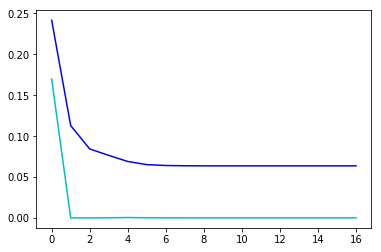

In [44]:
%matplotlib inline
plt.plot(err2_out, c='b')
plt.plot(err2_rec, c='c')

## Constraint for Orthogonal Weights

In [45]:
weight_vec = layer1_weights.weights[:,0]
weight_vec

array([ 0.13481365, -0.99068303])

In [46]:
rand_vec = np.random.uniform(size=2)
rand_vec = rand_vec/np.linalg.norm(rand_vec, ord=2)
rand_vec

array([0.47862699, 0.87801834])

In [47]:
np.cross(weight_vec, rand_vec)

array(0.59253649)

In [48]:
v1 = np.random.uniform(size=3)
v1 = v1/np.linalg.norm(v1, ord=2)
v1

array([0.20801787, 0.31230717, 0.92692653])

In [49]:
v2 = np.random.uniform(size=3)
v2 = v2/np.linalg.norm(v2, ord=2)
v2

array([0.33673977, 0.74863552, 0.57109647])

In [50]:
np.cross(v1, v2)

array([-0.51557261,  0.19333476,  0.05056332])

## Making of 2 layer double relu

In [56]:
# optimizer = tnn.Adam()
# n_hidden=2
# net = tnn.AutoForm(new_layers=True)
# layer1 = tnn.LinearLayer(2,n_hidden, optimizer=optimizer)
# layer2 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
# layer3 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
# layer4 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
# layer5 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)

# layern = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)

In [7]:
optimizer = tnn.SGD(learning_rate=0.1)
n_hidden=2
net = tnn.AutoForm(new_layers=True)
layer1 = tnn.LinearLayer(2,n_hidden, optimizer=optimizer)
layer2 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
layer3 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
layer4 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)
layer5 = tnn.DoubleReluLinearLayer(n_hidden,n_hidden, optimizer=optimizer)

layer1y = tnn.LinearLayer(2, 1, optimizer=optimizer)
layer2y = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)
layer3y = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)
layer4y = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)
layer5y = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)

layern = tnn.DoubleReluLinearLayer(n_hidden, 1, optimizer=optimizer)

In [8]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):
#     yout = net.forward(xx)
#     dy = tnn.MseLoss.del_loss(yout, yy)
#     dx = net.backward(dy)
    
    a1 = layer1.forward(xx)
    y1 = layer1y.forward(xx)
    
    a2 = layer2.forward(a1)
    y2 = layer2y.forward(a1)
    
    a3 = layer3.forward(a2)
    y3 = layer3y.forward(a2)
    
    a4 = layer4.forward(a3)
    y4 = layer4y.forward(a3)
    
    a5 = layer5.forward(a4)
    y5 = layer5y.forward(a4)
    
    yn = layern.forward(a5)
    
    yout = y1+y2+y3+y4+y5+yn
    
    dy = tnn.MseLoss.del_loss(yout, yy)

    da5 = layern.backward(dy)
    da4 = layer5y.backward(dy) + layer5.backward(da5)
    da3 = layer4y.backward(dy) + layer4.backward(da4)
    da2 = layer3y.backward(dy) + layer3.backward(da3)
    da1 = layer2y.backward(dy) + layer2.backward(da2)
    dx = layer1y.backward(dy) + layer1.backward(da1)
    
    
    
    net.update()
    
    if epoch%100 == 0:
            
        error = (dy**2).mean()
        print(epoch, f'Error_output = {error} ')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.1)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error_output = 0.8928418185705079 


100 Error_output = 0.07824629223091008 


200 Error_output = 0.04658774522979472 


300 Error_output = 0.02878344113530561 


400 Error_output = 0.0277297054235171 


500 Error_output = 0.0271151859323113 


600 Error_output = 0.02663603063494671 


700 Error_output = 0.026178717446432607 


800 Error_output = 0.02570676665029069 


900 Error_output = 0.025232066619877782 


1000 Error_output = 0.02474929436437497 


1100 Error_output = 0.024227789966781897 


1200 Error_output = 0.023711641280570614 


1300 Error_output = 0.023194740419880806 


1400 Error_output = 0.022615200317971797 


1500 Error_output = 0.021919856497534407 


1600 Error_output = 0.021256044046229612 


1700 Error_output = 0.020718786272779417 


1800 Error_output = 0.02038320779753849 


1900 Error_output = 0.020108669399011448 


2000 Error_output = 0.01989974962880061 


2100 Error_output = 0.019733599434237716 


2200 Error_output = 0.01959317972190421 


2300 Error_outp

TclError: can't invoke "update" command: application has been destroyed

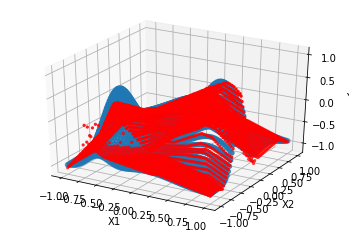

In [53]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()